## Change Log
- Use KL divergence in custom loss function
- determin number of bins for distributions using Freedman-Diaconis rule
- added test_size to config
- now using CUDA (GPU) instead of CPU (if NVIDIA Cuda available)
- save output data and models for multiple runs

In [2]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import math

import sys
import os
sys.path.append(os.getcwd() + "/pytorch_tabnet/")

from sklearn.cluster import DBSCAN
from scipy.special import rel_entr

## 0. Experiment Setup

In [4]:
# should an output folder be created to save the experiment data?
save_output = True

In [5]:
# read config file
import toml
config = toml.load("config.toml")

# rnd seed to support reproducable results
seed_value =  config["general"]["random_seed"] if config["general"]["random_seed"] else random.randrange(sys.maxsize)
random.seed(seed_value)

# TabNet hyperparameters
regressor_param = {"optimizer_fn" : torch.optim.Adam,
                   "optimizer_params" : {"lr":0.05},
                   "scheduler_params" : {"step_size": 2, "gamma": 0.9},
                   "scheduler_fn" : torch.optim.lr_scheduler.StepLR,
                   "mask_type" : 'entmax',
                   "device_name" : 'cuda', # only working on NVIDIA GPUs
                  }

if save_output:
    # create experiment folder
    from datetime import datetime
    
    experiment_name = config["general"]["experiment_name"]
    experiment_folder = f"{experiment_name} {datetime.now().strftime('%Y_%m_%d %H-%M-%S')}" if experiment_name else f"Exp {datetime.now().strftime('%Y_%m_%d %H-%M-%S')}"
    
    experiment_path = os.path.join("Experiments", experiment_folder)
    os.mkdir(experiment_path)
    
    plots_path = os.path.join(experiment_path, "plots")
    os.mkdir(plots_path)
    
    models_path = os.path.join(experiment_path, "models")
    os.mkdir(models_path)
    
    # save config file
    import shutil
    shutil.copy2("config.toml", experiment_path)
    
    # save random seed
    if not config["general"]["random_seed"]:
        config["general"]["random_seed"] = seed_value
        config_path = os.path.join(experiment_path, "config.toml")
        with open(config_path, "w") as f:
            toml.dump(config, f)
    
    # save model hyperparameters
    with open(os.path.join(experiment_path, 'config.toml'), 'a') as config_file:
        config_file.write("\n#[regressor_param]\n")
        for key, value in regressor_param.items(): 
            config_file.write('#%s = %s\n' % (key, str(value)))
    
    # save notebook
    shutil.copy2(nb_name, experiment_path)#
    
    # create output file
    output_path = os.path.join(experiment_path, "output.toml")
    output_file = open(output_path, "w")
    output = {}

## 1. Datasets

Different datasets are to be used for the experiments.
- toy dataset using make_blobs from sklearn mainly to setup and test the notebook
- DAMI Benchmark datasets with the respective best practice hyperparameters (https://www.dbs.ifi.lmu.de/research/outlier-evaluation/DAMI/)

### 1.0. Create toy dataset
As of now, only a toy dataset is used (n_features features with clusters centered around different points).

In [6]:
from sklearn.datasets import make_blobs

features_arr, clusters_arr = make_blobs(**config["toy_data"])

# name feature and cluster (ground truth) columns
features = pd.DataFrame(features_arr, columns=[f"F{x + 1}" for x in range(features_arr.shape[1])])
clusters = pd.DataFrame(clusters_arr, columns=["C"])

### 1.1. plot data

<IPython.core.display.Javascript object>


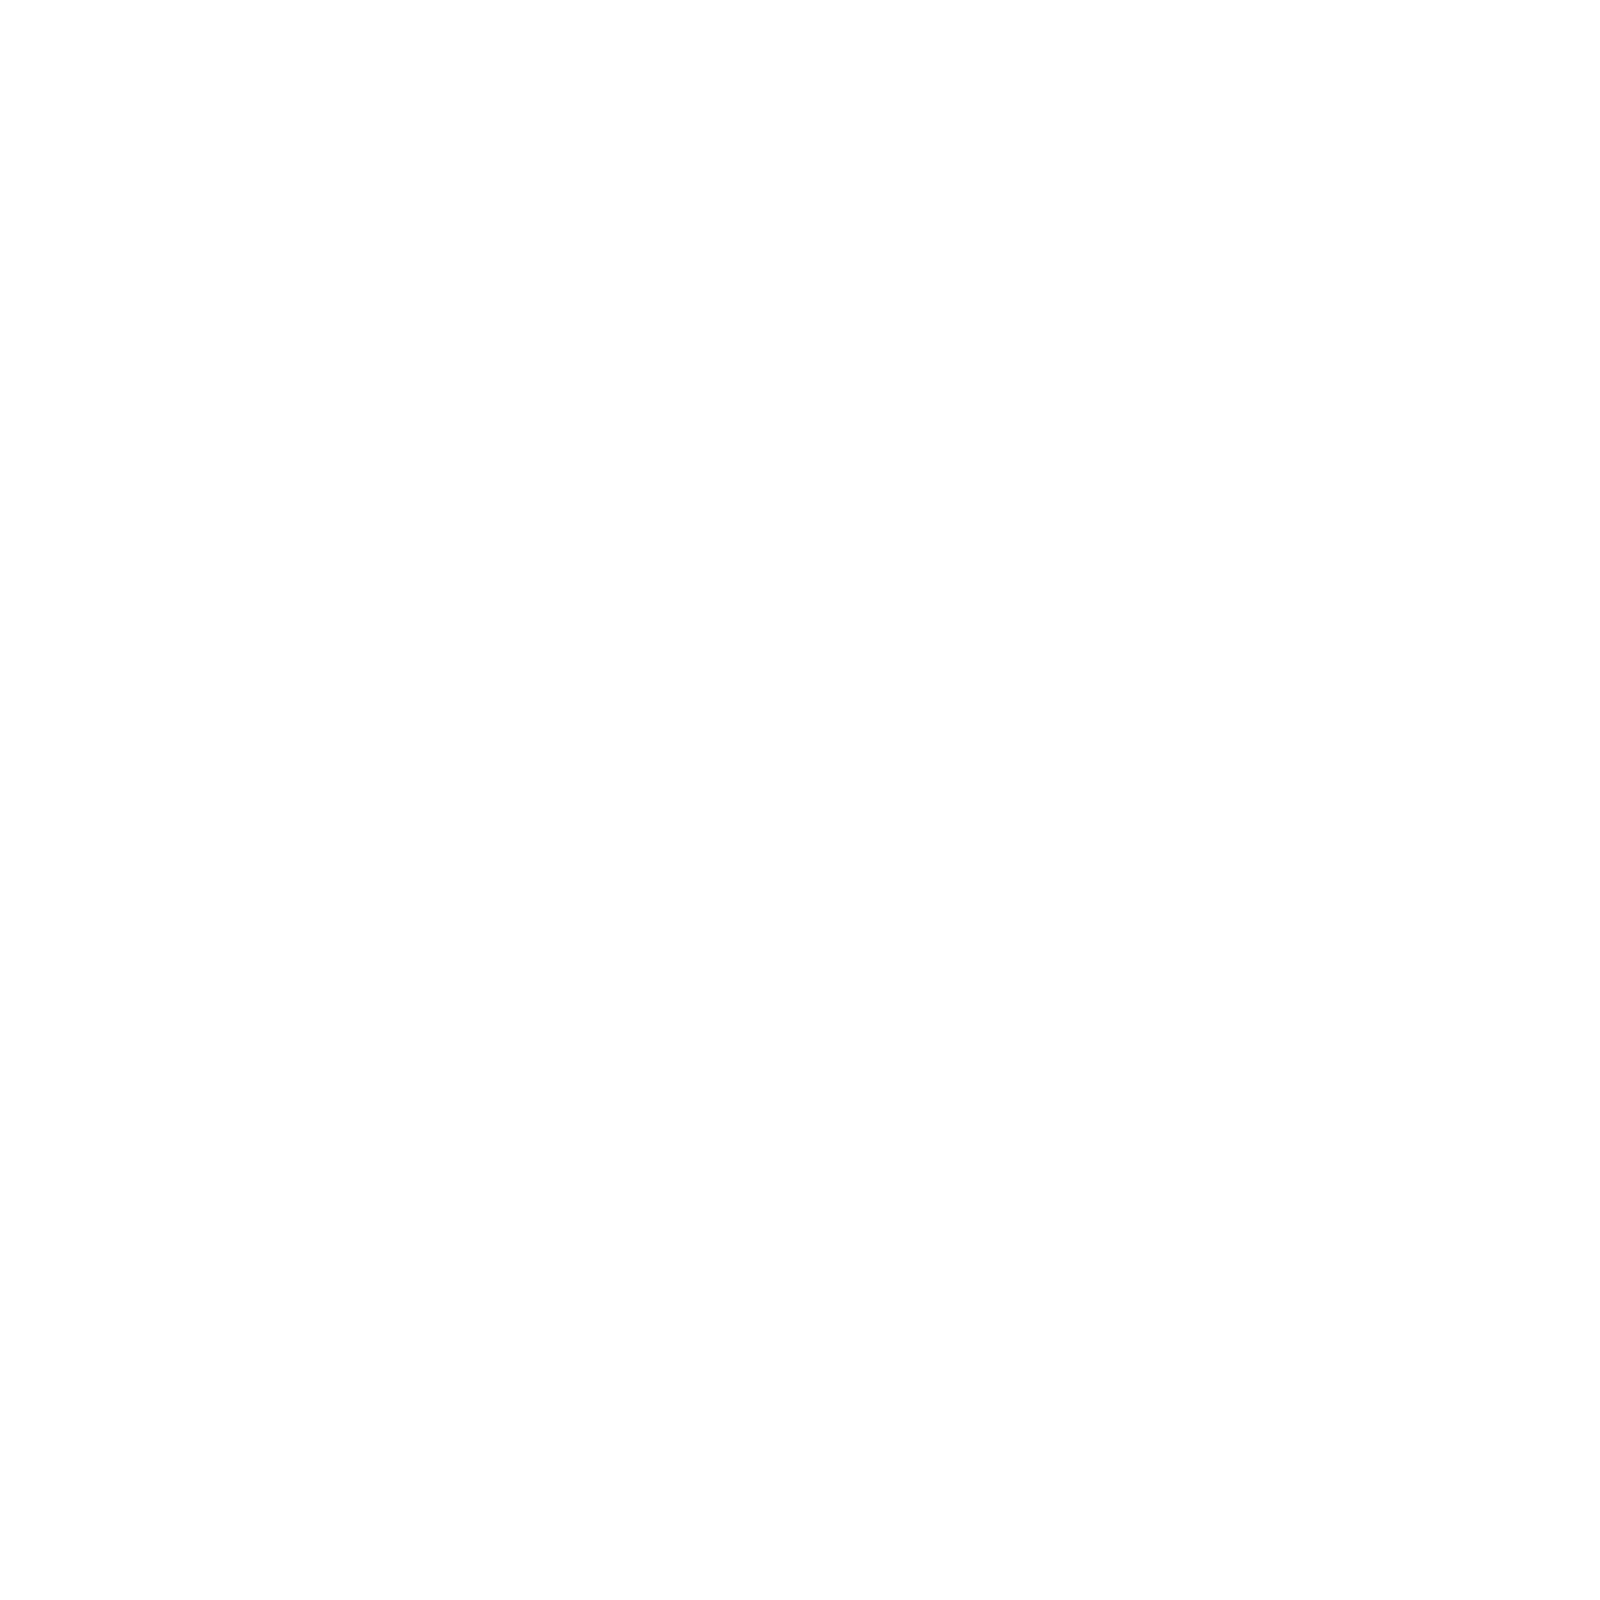

In [7]:
# plot dataset
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_arr[:, 0], features_arr[:, 1], features_arr[:, 2], c=clusters_arr)
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "0_ground_truth_clusters.png"), **config["plots"])

### 1.2. Create missing data
Create a specified amount of missing values in the given feature columns (for complete datasets).

In [8]:
# create missing values in feature column(s)
mv_config = {feature:mv_ratio for feature,mv_ratio in zip(list(features.columns), config["general"]["missing_percent"])}
features_mv = features.copy()

for f, mv in mv_config.items():
    features_mv[f] = features_mv[f].mask(np.random.random(features.shape[0]) < mv)

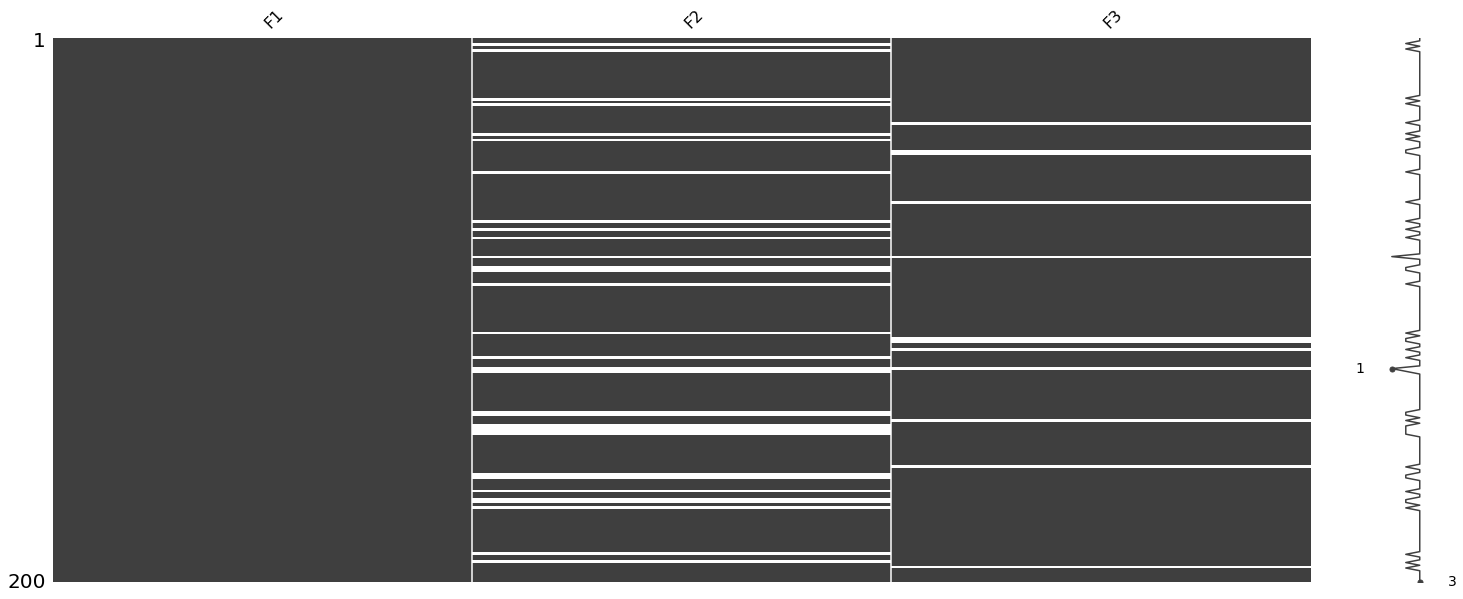

In [9]:
import missingno as msno
%matplotlib inline

# plot missing values
fig = msno.matrix(features_mv)
plt.show()
if save_output:
    #plt.savefig(os.path.join(plots_path, "missing_values.png"), **config["plots"])
    fig_copy = fig.get_figure()
    fig_copy.savefig(os.path.join(plots_path, "missing_values.png"), **config["plots"], bbox_inches = 'tight')

### 1.3. Initial Clustering (without missing values)
Use the cluster algorithm on dataset without missing values.\
Get cluster means for loss function input.

In [10]:
# run DBSCAN on original data
dbscan_orig = DBSCAN(**config["DBSCAN"]).fit(features)
clusters_orig = dbscan_orig.labels_

<IPython.core.display.Javascript object>


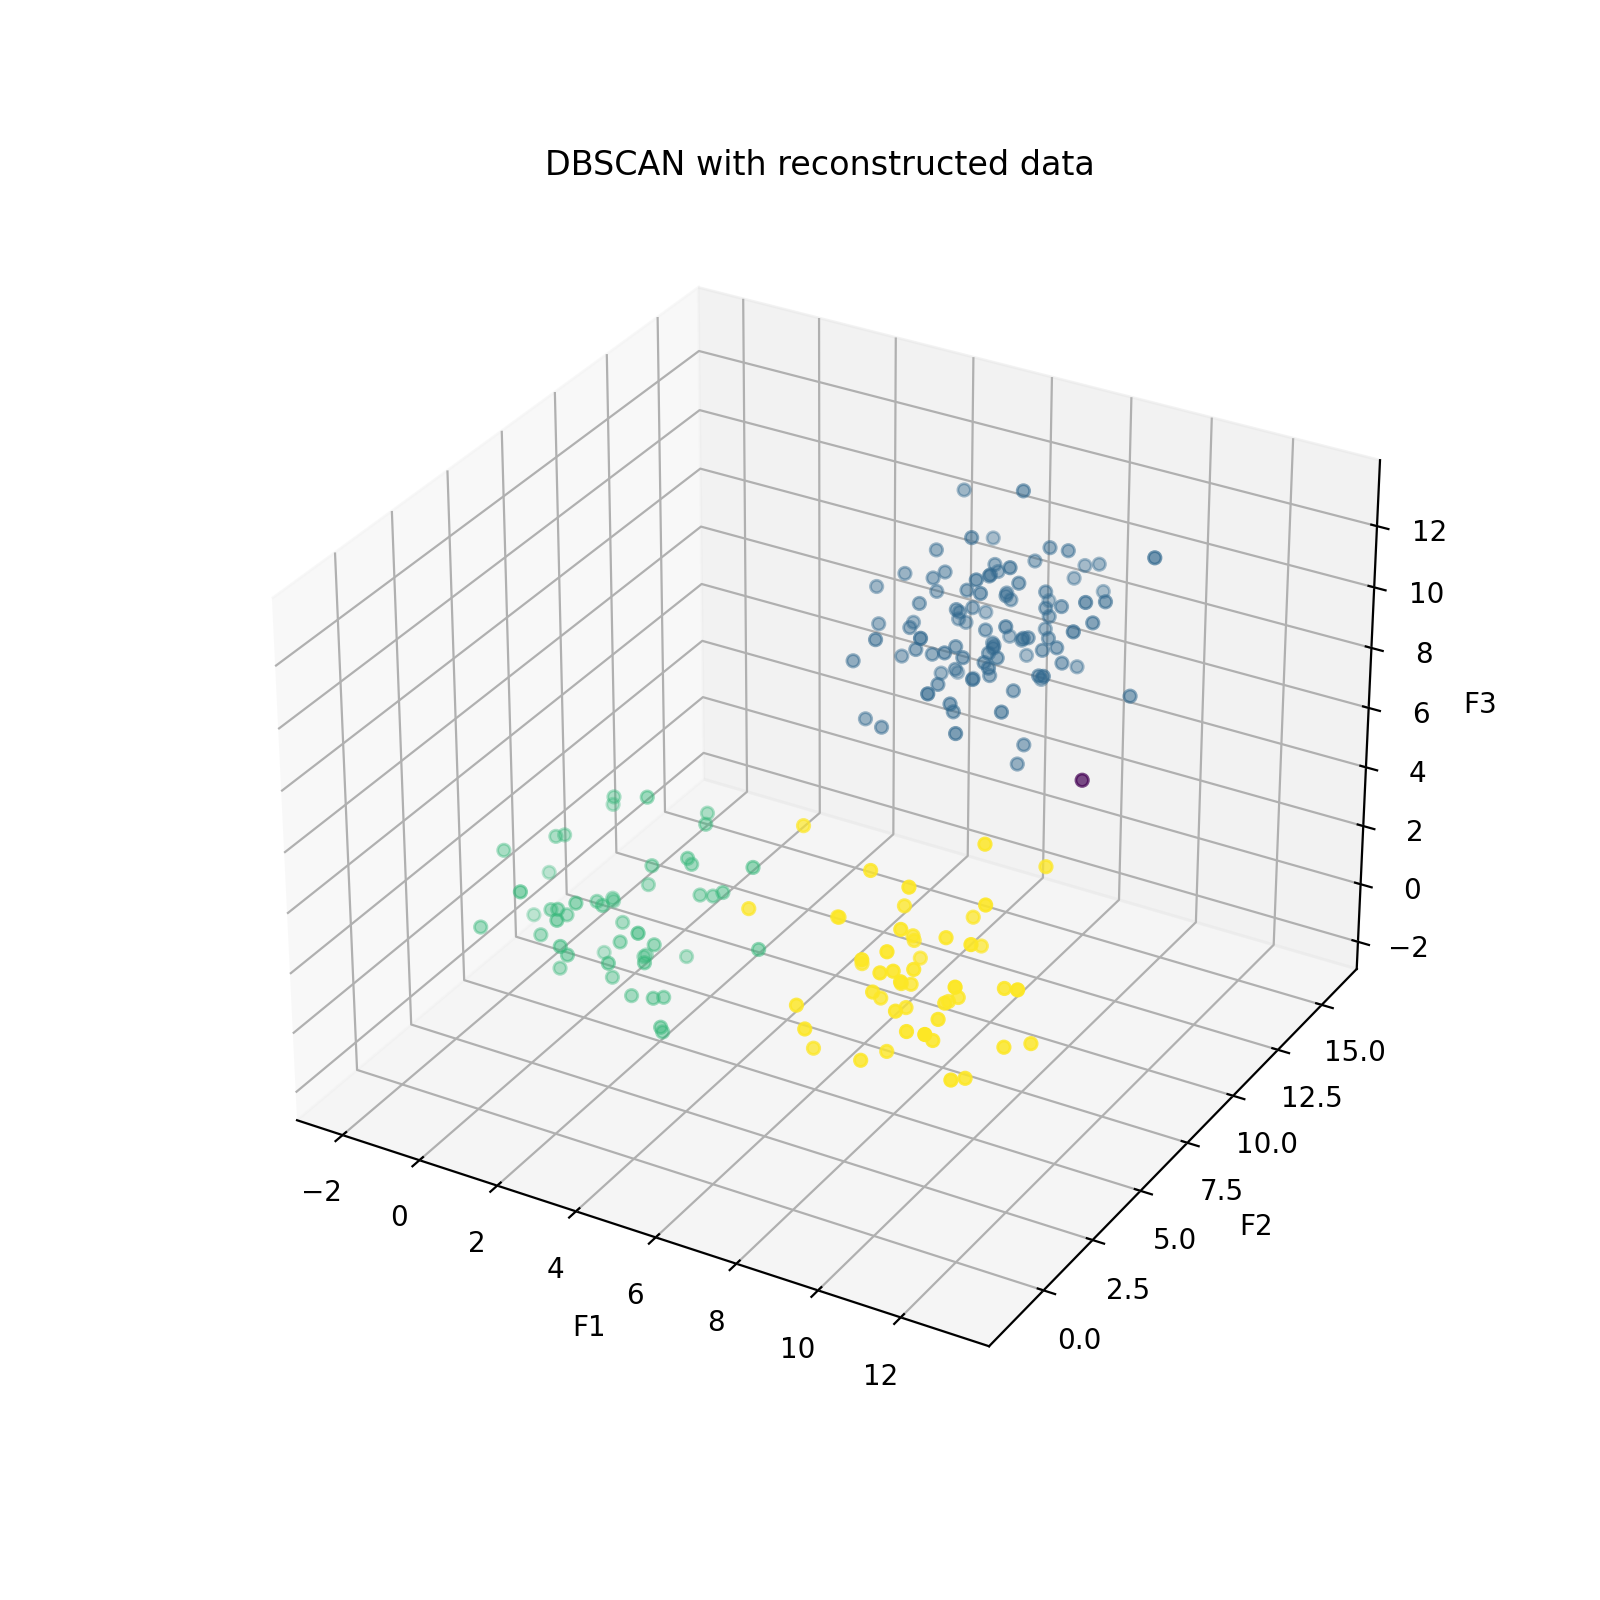

In [11]:
# plot clustering
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features.iloc[:, 0], features.iloc[:, 1], features.iloc[:, 2], c=clusters_orig)
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "1_DBSCAN_original_data.png"), **config["plots"])

In [12]:
# get cluster means (used to calculate the cluster mean loss)
complete_data = features.copy()
complete_data["C"] = clusters_orig
cluster_means = complete_data.groupby("C").agg("mean")
cluster_means = cluster_means if -1 not in cluster_means.index else cluster_means.drop(-1)

## 2. Filling Strategies


### 2.1. Define custom-loss
The loss function for the model fitting shall be customized to improve cluster perforamnce. The custom loss is divided into 2 separate losses

1. **Reconstruction Loss**\
Classic loss function, such as RMSE.
2. **Cluster-Mean Loss**\
The distance to the nearest cluster mean shall be minimized.
3. **KL Divergence Loss**\
Deviation of original distribution shall be minimized \
(prob distribution based on https://stackoverflow.com/questions/57687458/how-to-calculate-probabilities-using-numpy-histogram-and-then-use-it-for-calcula \
number of bins: D. Freedman & P. Diaconis (1981) “On the histogram as a density estimator: L2 theory”. Probability Theory and Related Fields 57 (4): 453-476)

The chosen approach to implement the cluster-mean loss is as follows:\
**Adapt the loss function** to calculate a distance to each cluster. The minimum distance (to the nearest cluster) will be used as a cluster-mean-loss. Minimizing this loss should result in the data point moving closer to the nearest cluster mean.\
Potential Problem: loss functions currently work with y_true (true values) and y_score (predicted values). Calculating the distance would require all features. Calculating only the 1 dimensional distance will result in missing values being put into wrong clusters - depending on the first estimate.

In [13]:
# define custom loss function: extend L2-loss by cluster-mean-loss

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import mean_squared_error
import astropy.stats

class custom_loss(Metric):

    def __init__(self):
        self._name = "custom_loss"
        self._maximize = False

    def __call__(self, y_true, y_score, cluster_means, target_feature, x_val, y_val):
        # reconstruction loss
        rmse = np.sqrt(mean_squared_error(y_true, y_score))
        
        # cluster mean loss
        cml = self.cluster_mean_loss(cluster_means, y_score, target_feature, x_val, y_val)
        
        # KL divergence loss
        bins = len(astropy.stats.freedman_bin_width(y_true.reshape(1,-1)[0], return_bins=True)[1])
        distr1, distr2 = self.probability_dist(y_score, y_true, bins)
        KLdl = torch.nn.functional.kl_div(torch.tensor(distr1).log(), torch.tensor(distr2), log_target=False, reduction='sum').item()
        
        # total loss
        custom_loss = rmse + KLdl + cml
        return custom_loss
    
    # calculate sum of distances to the closest cluster mean
    def cluster_mean_loss(self, cluster_means, y_score, target_feature, x_val, y_val):
        
        # reorder cluster_means to match x_val columns (predicted feature is last column)
        cols = cluster_means.columns.tolist()
        feature_col = features.columns.get_loc(target_feature)
        cols = cols[:feature_col] + cols[feature_col+1:] + [target_feature]
        
        # x values extended by predicted values
        x_extended = pd.DataFrame(np.hstack((x_val, y_score)), columns=cols)


        # calculate distances to each cluster and select the closest one
        dist = []
        for cluster in range(cluster_means.shape[0]):
            dist.append(np.linalg.norm((x_extended - cluster_means.iloc[cluster]), axis=1))
            
        dist = pd.DataFrame(dist).T
        min_dist = dist.assign(min_dist=lambda d: d.min(1))["min_dist"]
        
        return sum(min_dist)
    
    # calculate probabilities
    def probability_dist(self, x, y, bins):
        # transforms 2 series into their probability distributions
        # histogram
        hist_xy = np.histogram2d(np.asarray(x)[:,0], np.asarray(y)[:,0], bins=bins)[0]

        # compute marginals
        hist_xy = hist_xy + sys.float_info.min # prevent division with 0
        hist_xy = hist_xy / np.sum(hist_xy)
        hist_x = np.sum(hist_xy, axis=1)
        hist_y = np.sum(hist_xy, axis=0)
        return(hist_x, hist_y)

### 2.2. Fill missing values (TabNet).

**Approach 1:**\
For each feature that contains missing values, use all rows with complete other features as train set and predict missing values of the feature.\
&rarr; Problem: lots of models, especially for high-dimensional datasets. 
Also problem, if more than one feature is missing values. &rarr; see Approach 2

**Approach 2:**\
Mask missing values as -1 (or some other value) and fit a model predicting each feature just like in approach 1.\
&rarr; one model for each feature containing missing values.\
Possible adaption: use predicted values to predict subsequent values (instead of using -1)

In [14]:
import time

from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

features_to_predict = features_mv.columns[features_mv.isnull().any()]
features_reconstr = []
costs = {}
output["runtimes"] = {}

for run in range(config["RQ2"]["runs"]):
    time_start = time.time()
    features_reconstr.append(features_mv.copy())
    costs[run] = []
    for feature in features_to_predict:
        print(f"Run {run+1}, predicting {feature}")

        # select % of features for prediction based on pred_features (e.g. 10% of randomly selected features)
        number_of_features = math.ceil(config["RQ2"]["pred_features"] * (len(features_mv.columns)) - 1)
        features_mv_masked = features_mv.copy().drop(feature, axis=1).sample(n=number_of_features, axis='columns')
        selected_features = features_mv_masked.columns
        
        print(f"Predictions based on features {list(selected_features)}")
        
        # mask other columns' missing values as defined in config (missing_value_mask)
        features_mv_masked[feature] = features_mv[feature]
        features_mv_masked[selected_features] = features_mv_masked[(selected_features)].fillna(config["general"]["missing_value_mask"])
        
        # separate complete rows as train data
        # separate column with missing values as target
        test_data = features_mv_masked[features_mv_masked[feature].isna()].drop(feature, axis=1).to_numpy()
        train_data = features_mv_masked[features_mv_masked[feature].notna()]
        train_features = train_data.drop(columns=feature).to_numpy()
        train_target = train_data[feature].to_numpy().reshape(-1,1)

        x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, test_size=config["training"]["test_size"])

        # create & train model
        model = TabNetRegressor(**regressor_param)
        model.fit(
            x_train, y_train,
            eval_set=[(x_val, y_val)],
            eval_metric=['custom_loss'],
            **config["model_param"],
            cluster_means=cluster_means,
            target_feature=feature,
            x_val=x_val,
            y_val=y_val,
        )

        #track runtime
        time_end = time.time()
        
        # add costs to dict
        costs[run].append(model.best_cost)
        

        # fill missing values with model predictions
        features_reconstr[run].loc[features_reconstr[run][feature].isna(), feature] = [x[0] for x in model.predict(test_data)]

        # save outputs
        if save_output:
            
            # save model
            torch.save(model, os.path.join(models_path, f"Model_run{run}_{feature}.pt"))
            
            # save runtimes
            output["runtimes"][f"run{run}_{feature}"] = time_end - time_start


Run 1, predicting F2
Predictions based on features ['F1', 'F3']
Device used : cpu
epoch 0  | loss: 49.47562| val_0_custom_loss: 2292.10619|  0:00:00s
epoch 1  | loss: 28.42315| val_0_custom_loss: 1117.25717|  0:00:00s
epoch 2  | loss: 13.62451| val_0_custom_loss: 1401.61261|  0:00:00s
epoch 3  | loss: 8.93831 | val_0_custom_loss: 1640.99311|  0:00:00s
epoch 4  | loss: 7.64595 | val_0_custom_loss: 1296.79111|  0:00:00s
epoch 5  | loss: 6.66104 | val_0_custom_loss: 973.73169|  0:00:00s
epoch 6  | loss: 5.55147 | val_0_custom_loss: 765.80384|  0:00:00s
epoch 7  | loss: 4.82764 | val_0_custom_loss: 651.80116|  0:00:00s
epoch 8  | loss: 4.01778 | val_0_custom_loss: 608.39075|  0:00:00s
epoch 9  | loss: 3.77024 | val_0_custom_loss: 570.39836|  0:00:00s
epoch 10 | loss: 3.42832 | val_0_custom_loss: 621.1338|  0:00:00s
epoch 11 | loss: 3.37827 | val_0_custom_loss: 690.64546|  0:00:00s
epoch 12 | loss: 3.18201 | val_0_custom_loss: 708.96093|  0:00:00s
epoch 13 | loss: 3.04372 | val_0_custom_los

epoch 123| loss: 2.03518 | val_0_custom_loss: 113.14845|  0:00:06s
epoch 124| loss: 2.035   | val_0_custom_loss: 112.98521|  0:00:06s
epoch 125| loss: 2.03484 | val_0_custom_loss: 112.79773|  0:00:06s
epoch 126| loss: 2.03468 | val_0_custom_loss: 112.6518|  0:00:06s
epoch 127| loss: 2.03454 | val_0_custom_loss: 112.51875|  0:00:06s
epoch 128| loss: 2.03438 | val_0_custom_loss: 112.40096|  0:00:06s
epoch 129| loss: 2.03429 | val_0_custom_loss: 112.27848|  0:00:06s
epoch 130| loss: 2.03418 | val_0_custom_loss: 112.19846|  0:00:06s
epoch 131| loss: 2.03404 | val_0_custom_loss: 112.11511|  0:00:06s
epoch 132| loss: 2.03395 | val_0_custom_loss: 112.09737|  0:00:06s
epoch 133| loss: 2.03388 | val_0_custom_loss: 112.07123|  0:00:06s
epoch 134| loss: 2.0338  | val_0_custom_loss: 112.0356|  0:00:06s
epoch 135| loss: 2.03371 | val_0_custom_loss: 112.01731|  0:00:06s
epoch 136| loss: 2.03363 | val_0_custom_loss: 111.97633|  0:00:07s
epoch 137| loss: 2.03355 | val_0_custom_loss: 111.91091|  0:00:0

epoch 248| loss: 2.03207 | val_0_custom_loss: 107.9605|  0:00:10s
epoch 249| loss: 2.03207 | val_0_custom_loss: 107.94428|  0:00:10s
epoch 250| loss: 2.03207 | val_0_custom_loss: 107.9293|  0:00:10s
epoch 251| loss: 2.03207 | val_0_custom_loss: 107.91596|  0:00:10s
epoch 252| loss: 2.03207 | val_0_custom_loss: 107.90377|  0:00:10s
epoch 253| loss: 2.03207 | val_0_custom_loss: 107.89245|  0:00:10s
epoch 254| loss: 2.03207 | val_0_custom_loss: 107.882 |  0:00:10s
epoch 255| loss: 2.03207 | val_0_custom_loss: 107.8724|  0:00:10s
epoch 256| loss: 2.03207 | val_0_custom_loss: 107.86361|  0:00:10s
epoch 257| loss: 2.03207 | val_0_custom_loss: 107.85563|  0:00:10s
epoch 258| loss: 2.03207 | val_0_custom_loss: 107.84845|  0:00:10s
epoch 259| loss: 2.03207 | val_0_custom_loss: 107.84206|  0:00:11s
epoch 260| loss: 2.03207 | val_0_custom_loss: 107.83815|  0:00:11s
epoch 261| loss: 2.03207 | val_0_custom_loss: 107.83562|  0:00:11s
epoch 262| loss: 2.03207 | val_0_custom_loss: 107.83378|  0:00:11s

epoch 69 | loss: 1.92064 | val_0_custom_loss: 211.8402|  0:00:02s
epoch 70 | loss: 1.67081 | val_0_custom_loss: 209.96426|  0:00:02s
epoch 71 | loss: 1.97998 | val_0_custom_loss: 208.02216|  0:00:02s
epoch 72 | loss: 1.70154 | val_0_custom_loss: 206.66933|  0:00:02s
epoch 73 | loss: 1.56825 | val_0_custom_loss: 205.37096|  0:00:02s
epoch 74 | loss: 1.51552 | val_0_custom_loss: 203.96102|  0:00:02s
epoch 75 | loss: 1.85834 | val_0_custom_loss: 202.46891|  0:00:02s
epoch 76 | loss: 2.07127 | val_0_custom_loss: 201.24438|  0:00:02s
epoch 77 | loss: 1.89338 | val_0_custom_loss: 200.08312|  0:00:02s
epoch 78 | loss: 1.57149 | val_0_custom_loss: 198.87025|  0:00:02s
epoch 79 | loss: 1.65901 | val_0_custom_loss: 197.711 |  0:00:02s
epoch 80 | loss: 1.66997 | val_0_custom_loss: 196.44602|  0:00:02s
epoch 81 | loss: 2.16371 | val_0_custom_loss: 195.06547|  0:00:03s
epoch 82 | loss: 1.7296  | val_0_custom_loss: 194.03763|  0:00:03s
epoch 83 | loss: 1.70748 | val_0_custom_loss: 193.07282|  0:00:0

epoch 196| loss: 1.58719 | val_0_custom_loss: 138.09113|  0:00:07s
epoch 197| loss: 1.6302  | val_0_custom_loss: 137.89628|  0:00:07s
epoch 198| loss: 2.7479  | val_0_custom_loss: 137.66096|  0:00:07s
epoch 199| loss: 1.71545 | val_0_custom_loss: 137.47456|  0:00:07s
epoch 200| loss: 1.67215 | val_0_custom_loss: 137.2694|  0:00:07s
epoch 201| loss: 2.06699 | val_0_custom_loss: 137.11695|  0:00:08s
epoch 202| loss: 1.6322  | val_0_custom_loss: 136.95176|  0:00:08s
epoch 203| loss: 1.93324 | val_0_custom_loss: 136.80285|  0:00:08s
epoch 204| loss: 1.62772 | val_0_custom_loss: 136.64551|  0:00:08s
epoch 205| loss: 1.56344 | val_0_custom_loss: 136.48882|  0:00:08s
epoch 206| loss: 1.63617 | val_0_custom_loss: 136.33032|  0:00:08s
epoch 207| loss: 1.78902 | val_0_custom_loss: 136.17225|  0:00:08s
epoch 208| loss: 1.80589 | val_0_custom_loss: 136.01003|  0:00:08s
epoch 209| loss: 1.81513 | val_0_custom_loss: 135.88166|  0:00:08s
epoch 210| loss: 1.55838 | val_0_custom_loss: 135.77304|  0:00:

epoch 20 | loss: 3.03832 | val_0_custom_loss: 841.81396|  0:00:00s
epoch 21 | loss: 2.97071 | val_0_custom_loss: 753.08542|  0:00:00s
epoch 22 | loss: 2.92634 | val_0_custom_loss: 692.24757|  0:00:00s
epoch 23 | loss: 2.88283 | val_0_custom_loss: 662.01248|  0:00:00s
epoch 24 | loss: 2.84168 | val_0_custom_loss: 624.42636|  0:00:00s
epoch 25 | loss: 2.79392 | val_0_custom_loss: 598.75393|  0:00:00s
epoch 26 | loss: 2.76569 | val_0_custom_loss: 575.65333|  0:00:00s
epoch 27 | loss: 2.73081 | val_0_custom_loss: 545.69415|  0:00:01s
epoch 28 | loss: 2.6844  | val_0_custom_loss: 527.92384|  0:00:01s
epoch 29 | loss: 2.65008 | val_0_custom_loss: 503.4668|  0:00:01s
epoch 30 | loss: 2.61052 | val_0_custom_loss: 478.1635|  0:00:01s
epoch 31 | loss: 2.5744  | val_0_custom_loss: 453.21283|  0:00:01s
epoch 32 | loss: 2.54596 | val_0_custom_loss: 416.19655|  0:00:01s
epoch 33 | loss: 2.50878 | val_0_custom_loss: 396.46641|  0:00:01s
epoch 34 | loss: 2.48461 | val_0_custom_loss: 386.43364|  0:00:0

epoch 144| loss: 1.91457 | val_0_custom_loss: 188.48428|  0:00:05s
epoch 145| loss: 1.91448 | val_0_custom_loss: 188.3296|  0:00:05s
epoch 146| loss: 1.91439 | val_0_custom_loss: 188.18522|  0:00:05s
epoch 147| loss: 1.91431 | val_0_custom_loss: 187.96104|  0:00:05s
epoch 148| loss: 1.91423 | val_0_custom_loss: 187.83118|  0:00:05s
epoch 149| loss: 1.91415 | val_0_custom_loss: 187.70722|  0:00:05s
epoch 150| loss: 1.91408 | val_0_custom_loss: 187.58891|  0:00:05s
epoch 151| loss: 1.91401 | val_0_custom_loss: 187.47612|  0:00:05s
epoch 152| loss: 1.91395 | val_0_custom_loss: 187.36862|  0:00:05s
epoch 153| loss: 1.91389 | val_0_custom_loss: 187.26769|  0:00:05s
epoch 154| loss: 1.91382 | val_0_custom_loss: 187.17336|  0:00:05s
epoch 155| loss: 1.91377 | val_0_custom_loss: 187.08596|  0:00:05s
epoch 156| loss: 1.91372 | val_0_custom_loss: 187.00512|  0:00:05s
epoch 157| loss: 1.91367 | val_0_custom_loss: 187.02313|  0:00:05s
epoch 158| loss: 1.91362 | val_0_custom_loss: 186.95212|  0:00:

epoch 269| loss: 1.91274 | val_0_custom_loss: 182.30045|  0:00:09s
epoch 270| loss: 1.91274 | val_0_custom_loss: 182.28568|  0:00:09s
epoch 271| loss: 1.91274 | val_0_custom_loss: 182.27155|  0:00:09s
epoch 272| loss: 1.91274 | val_0_custom_loss: 182.258 |  0:00:09s
epoch 273| loss: 1.91274 | val_0_custom_loss: 182.24505|  0:00:09s
epoch 274| loss: 1.91273 | val_0_custom_loss: 182.23266|  0:00:10s
epoch 275| loss: 1.91274 | val_0_custom_loss: 182.22086|  0:00:10s
epoch 276| loss: 1.91274 | val_0_custom_loss: 182.20956|  0:00:10s
epoch 277| loss: 1.91273 | val_0_custom_loss: 182.19672|  0:00:10s
epoch 278| loss: 1.91274 | val_0_custom_loss: 182.18443|  0:00:10s
epoch 279| loss: 1.91274 | val_0_custom_loss: 182.17264|  0:00:10s
epoch 280| loss: 1.91273 | val_0_custom_loss: 182.16137|  0:00:10s
epoch 281| loss: 1.91273 | val_0_custom_loss: 182.1506|  0:00:10s
epoch 282| loss: 1.91274 | val_0_custom_loss: 182.14033|  0:00:10s
epoch 283| loss: 1.91273 | val_0_custom_loss: 182.13056|  0:00:1

epoch 90 | loss: 1.98816 | val_0_custom_loss: 292.1361|  0:00:03s
epoch 91 | loss: 1.94127 | val_0_custom_loss: 291.38435|  0:00:03s
epoch 92 | loss: 1.88966 | val_0_custom_loss: 290.72247|  0:00:03s
epoch 93 | loss: 1.82626 | val_0_custom_loss: 290.09852|  0:00:03s
epoch 94 | loss: 1.96088 | val_0_custom_loss: 289.32361|  0:00:03s
epoch 95 | loss: 1.86929 | val_0_custom_loss: 288.5282|  0:00:03s
epoch 96 | loss: 1.97619 | val_0_custom_loss: 287.68432|  0:00:03s
epoch 97 | loss: 1.99459 | val_0_custom_loss: 286.73608|  0:00:03s
epoch 98 | loss: 2.0955  | val_0_custom_loss: 285.86709|  0:00:04s
epoch 99 | loss: 2.12482 | val_0_custom_loss: 284.96404|  0:00:04s
epoch 100| loss: 2.17162 | val_0_custom_loss: 283.95551|  0:00:04s
epoch 101| loss: 1.8728  | val_0_custom_loss: 283.10893|  0:00:04s
epoch 102| loss: 1.82564 | val_0_custom_loss: 282.22317|  0:00:04s
epoch 103| loss: 1.92222 | val_0_custom_loss: 281.32461|  0:00:04s
epoch 104| loss: 1.839   | val_0_custom_loss: 280.5118|  0:00:04

epoch 218| loss: 2.13816 | val_0_custom_loss: 273.47257|  0:00:07s
epoch 219| loss: 1.93621 | val_0_custom_loss: 273.50938|  0:00:07s
epoch 220| loss: 2.40533 | val_0_custom_loss: 273.5852|  0:00:08s
epoch 221| loss: 1.8086  | val_0_custom_loss: 273.57071|  0:00:08s
epoch 222| loss: 1.88732 | val_0_custom_loss: 273.58616|  0:00:08s
epoch 223| loss: 1.84931 | val_0_custom_loss: 273.61686|  0:00:08s
epoch 224| loss: 1.93617 | val_0_custom_loss: 273.60562|  0:00:08s
epoch 225| loss: 1.88047 | val_0_custom_loss: 273.61783|  0:00:08s
epoch 226| loss: 1.95792 | val_0_custom_loss: 273.64079|  0:00:08s
epoch 227| loss: 2.03829 | val_0_custom_loss: 273.69433|  0:00:08s

Early stopping occurred at epoch 227 with best_epoch = 177 and best_val_0_custom_loss = 272.7118
Best weights from best epoch are automatically used!
Run 3, predicting F2
Predictions based on features ['F3', 'F1']
Device used : cpu
epoch 0  | loss: 49.1271 | val_0_custom_loss: 7430.04846|  0:00:00s
epoch 1  | loss: 22.92173| val

epoch 109| loss: 2.31143 | val_0_custom_loss: 227.99672|  0:00:03s
epoch 110| loss: 2.31096 | val_0_custom_loss: 227.812 |  0:00:03s
epoch 111| loss: 2.3105  | val_0_custom_loss: 227.66032|  0:00:03s
epoch 112| loss: 2.31006 | val_0_custom_loss: 227.48887|  0:00:03s
epoch 113| loss: 2.30965 | val_0_custom_loss: 227.32464|  0:00:03s
epoch 114| loss: 2.30925 | val_0_custom_loss: 227.15987|  0:00:03s
epoch 115| loss: 2.30887 | val_0_custom_loss: 226.99822|  0:00:03s
epoch 116| loss: 2.30852 | val_0_custom_loss: 226.84121|  0:00:03s
epoch 117| loss: 2.30816 | val_0_custom_loss: 226.6925|  0:00:03s
epoch 118| loss: 2.30785 | val_0_custom_loss: 226.5768|  0:00:03s
epoch 119| loss: 2.30755 | val_0_custom_loss: 226.45954|  0:00:03s
epoch 120| loss: 2.30726 | val_0_custom_loss: 226.30258|  0:00:04s
epoch 121| loss: 2.30701 | val_0_custom_loss: 226.16638|  0:00:04s
epoch 122| loss: 2.30675 | val_0_custom_loss: 226.03421|  0:00:04s
epoch 123| loss: 2.30652 | val_0_custom_loss: 225.90564|  0:00:04

epoch 235| loss: 2.30186 | val_0_custom_loss: 209.48681|  0:00:08s
epoch 236| loss: 2.30186 | val_0_custom_loss: 209.42937|  0:00:08s
epoch 237| loss: 2.30186 | val_0_custom_loss: 209.37294|  0:00:08s
epoch 238| loss: 2.30186 | val_0_custom_loss: 209.31818|  0:00:08s
epoch 239| loss: 2.30186 | val_0_custom_loss: 209.26518|  0:00:08s
epoch 240| loss: 2.30186 | val_0_custom_loss: 209.21388|  0:00:08s
epoch 241| loss: 2.30186 | val_0_custom_loss: 209.13752|  0:00:08s
epoch 242| loss: 2.30186 | val_0_custom_loss: 209.06051|  0:00:08s
epoch 243| loss: 2.30186 | val_0_custom_loss: 208.98449|  0:00:08s
epoch 244| loss: 2.30186 | val_0_custom_loss: 208.93496|  0:00:08s
epoch 245| loss: 2.30186 | val_0_custom_loss: 208.86243|  0:00:08s
epoch 246| loss: 2.30186 | val_0_custom_loss: 208.79177|  0:00:08s
epoch 247| loss: 2.30186 | val_0_custom_loss: 208.72284|  0:00:08s
epoch 248| loss: 2.30185 | val_0_custom_loss: 208.65557|  0:00:08s
epoch 249| loss: 2.30185 | val_0_custom_loss: 208.58994|  0:00

epoch 54 | loss: 3.98771 | val_0_custom_loss: 312.9298|  0:00:02s
epoch 55 | loss: 4.03364 | val_0_custom_loss: 306.72838|  0:00:02s
epoch 56 | loss: 4.0695  | val_0_custom_loss: 301.36813|  0:00:02s
epoch 57 | loss: 4.03919 | val_0_custom_loss: 296.3489|  0:00:02s
epoch 58 | loss: 4.11775 | val_0_custom_loss: 290.42035|  0:00:02s
epoch 59 | loss: 4.0257  | val_0_custom_loss: 285.94829|  0:00:02s
epoch 60 | loss: 4.20517 | val_0_custom_loss: 281.35627|  0:00:02s
epoch 61 | loss: 3.94176 | val_0_custom_loss: 277.60785|  0:00:02s
epoch 62 | loss: 4.05638 | val_0_custom_loss: 273.99742|  0:00:02s
epoch 63 | loss: 4.01745 | val_0_custom_loss: 271.02562|  0:00:02s
epoch 64 | loss: 4.23969 | val_0_custom_loss: 267.99889|  0:00:02s
epoch 65 | loss: 3.9269  | val_0_custom_loss: 265.358 |  0:00:02s
epoch 66 | loss: 3.97319 | val_0_custom_loss: 262.63688|  0:00:02s
epoch 67 | loss: 4.18424 | val_0_custom_loss: 259.35821|  0:00:02s
epoch 68 | loss: 4.30758 | val_0_custom_loss: 255.95907|  0:00:02

epoch 178| loss: 3.84685 | val_0_custom_loss: 130.69659|  0:00:07s
epoch 179| loss: 4.02619 | val_0_custom_loss: 130.54444|  0:00:07s
epoch 180| loss: 4.04227 | val_0_custom_loss: 130.36122|  0:00:07s
epoch 181| loss: 3.95309 | val_0_custom_loss: 130.20404|  0:00:07s
epoch 182| loss: 4.23191 | val_0_custom_loss: 130.08967|  0:00:07s
epoch 183| loss: 4.02543 | val_0_custom_loss: 129.94859|  0:00:07s
epoch 184| loss: 4.1087  | val_0_custom_loss: 129.80652|  0:00:07s
epoch 185| loss: 3.94639 | val_0_custom_loss: 129.68628|  0:00:07s
epoch 186| loss: 4.09422 | val_0_custom_loss: 129.5808|  0:00:07s
epoch 187| loss: 4.19667 | val_0_custom_loss: 129.47918|  0:00:07s
epoch 188| loss: 3.99115 | val_0_custom_loss: 129.33831|  0:00:07s
epoch 189| loss: 4.15807 | val_0_custom_loss: 129.22775|  0:00:07s
epoch 190| loss: 4.07403 | val_0_custom_loss: 129.10246|  0:00:07s
epoch 191| loss: 4.04659 | val_0_custom_loss: 128.98207|  0:00:07s
epoch 192| loss: 3.90539 | val_0_custom_loss: 128.87509|  0:00:

## 3. Complete Dataset
Costs for each run

In [15]:
costs

{0: [107.13473017421846, 132.0618895935844],
 1: [181.9373354308797, 272.711804626101],
 2: [205.64317239167775, 124.34916806625105]}

### 3.1 Reconstruct Dataset
choose best model based on min. squared custom loss (punishing large outliers in losses for single features)

In [16]:
cost_totals = [sum([x**2 for x in c]) for _, c in costs.items()]
best_model = cost_totals.index(min(cost_totals))
features_best = features_reconstr[best_model]
print(f"Best model: run {best_model} with custom losses {costs[best_model]} for features {list(features_to_predict)}")

Best model: run 0 with custom losses [107.13473017421846, 132.0618895935844] for features ['F2', 'F3']


### 3.2 Plot changes (comp. to original data)

<IPython.core.display.Javascript object>


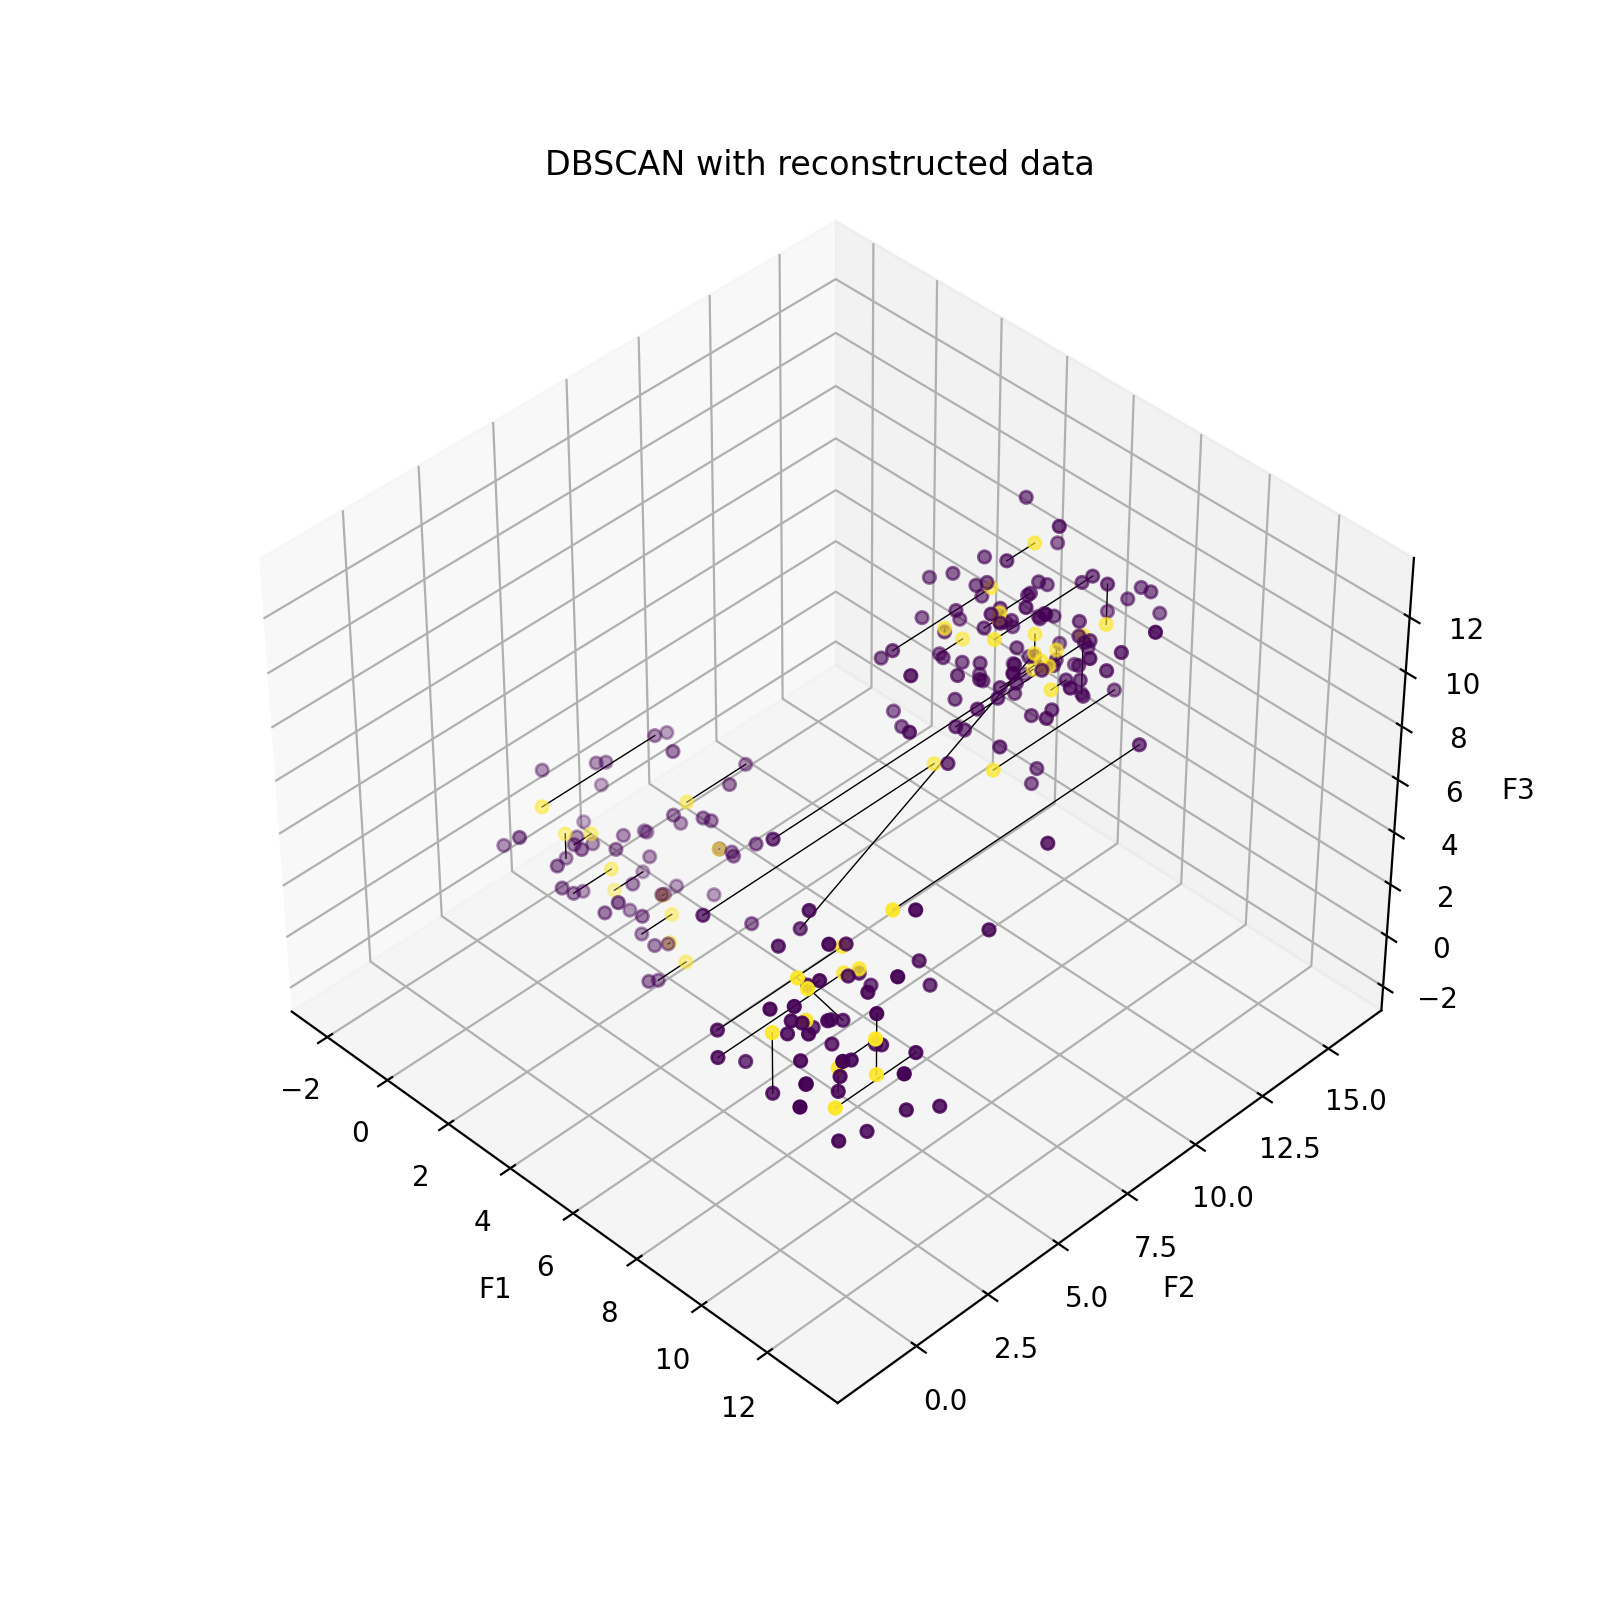

In [17]:
# scatter plot with combined data
orig_data = features.copy()
orig_data["change"] = 0
changed_data = features_best[features_mv.isna().any(axis=1)]
comp_data = pd.concat([orig_data, changed_data]).reset_index(drop=True).fillna(1)

# line plot connecting filled data to true data points
reconstr_data = features_best[features_mv.isna().any(axis=1)]
true_data = features[features_mv.isna().any(axis=1)]

# plot
fig = plt.figure(figsize=(8,8))
ax  = fig.add_subplot(projection = '3d')
ax.scatter(comp_data["F1"], comp_data["F2"], comp_data["F3"], c=[comp_data["change"]])

for i in range(len(reconstr_data)):
    ax.plot([reconstr_data["F1"].iloc[i], true_data["F1"].iloc[i]],[reconstr_data["F2"].iloc[i], true_data["F2"].iloc[i]],[reconstr_data["F3"].iloc[i], true_data["F3"].iloc[i]], color="black", linewidth=.5)


plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show
if save_output:
    plt.savefig(os.path.join(plots_path, "4_imputation_differences.png"), **config["plots"])

## 4. Clustering

In [18]:
# apply clustering
clusters_reconstr = []
for run in range(config["RQ2"]["runs"]):
    dbscan_reconstr = DBSCAN(**config["DBSCAN"]).fit(features_reconstr[run])
    clusters_reconstr.append(dbscan_reconstr.labels_)

### 4.1. Plot of clustering based on best model predictions

<IPython.core.display.Javascript object>


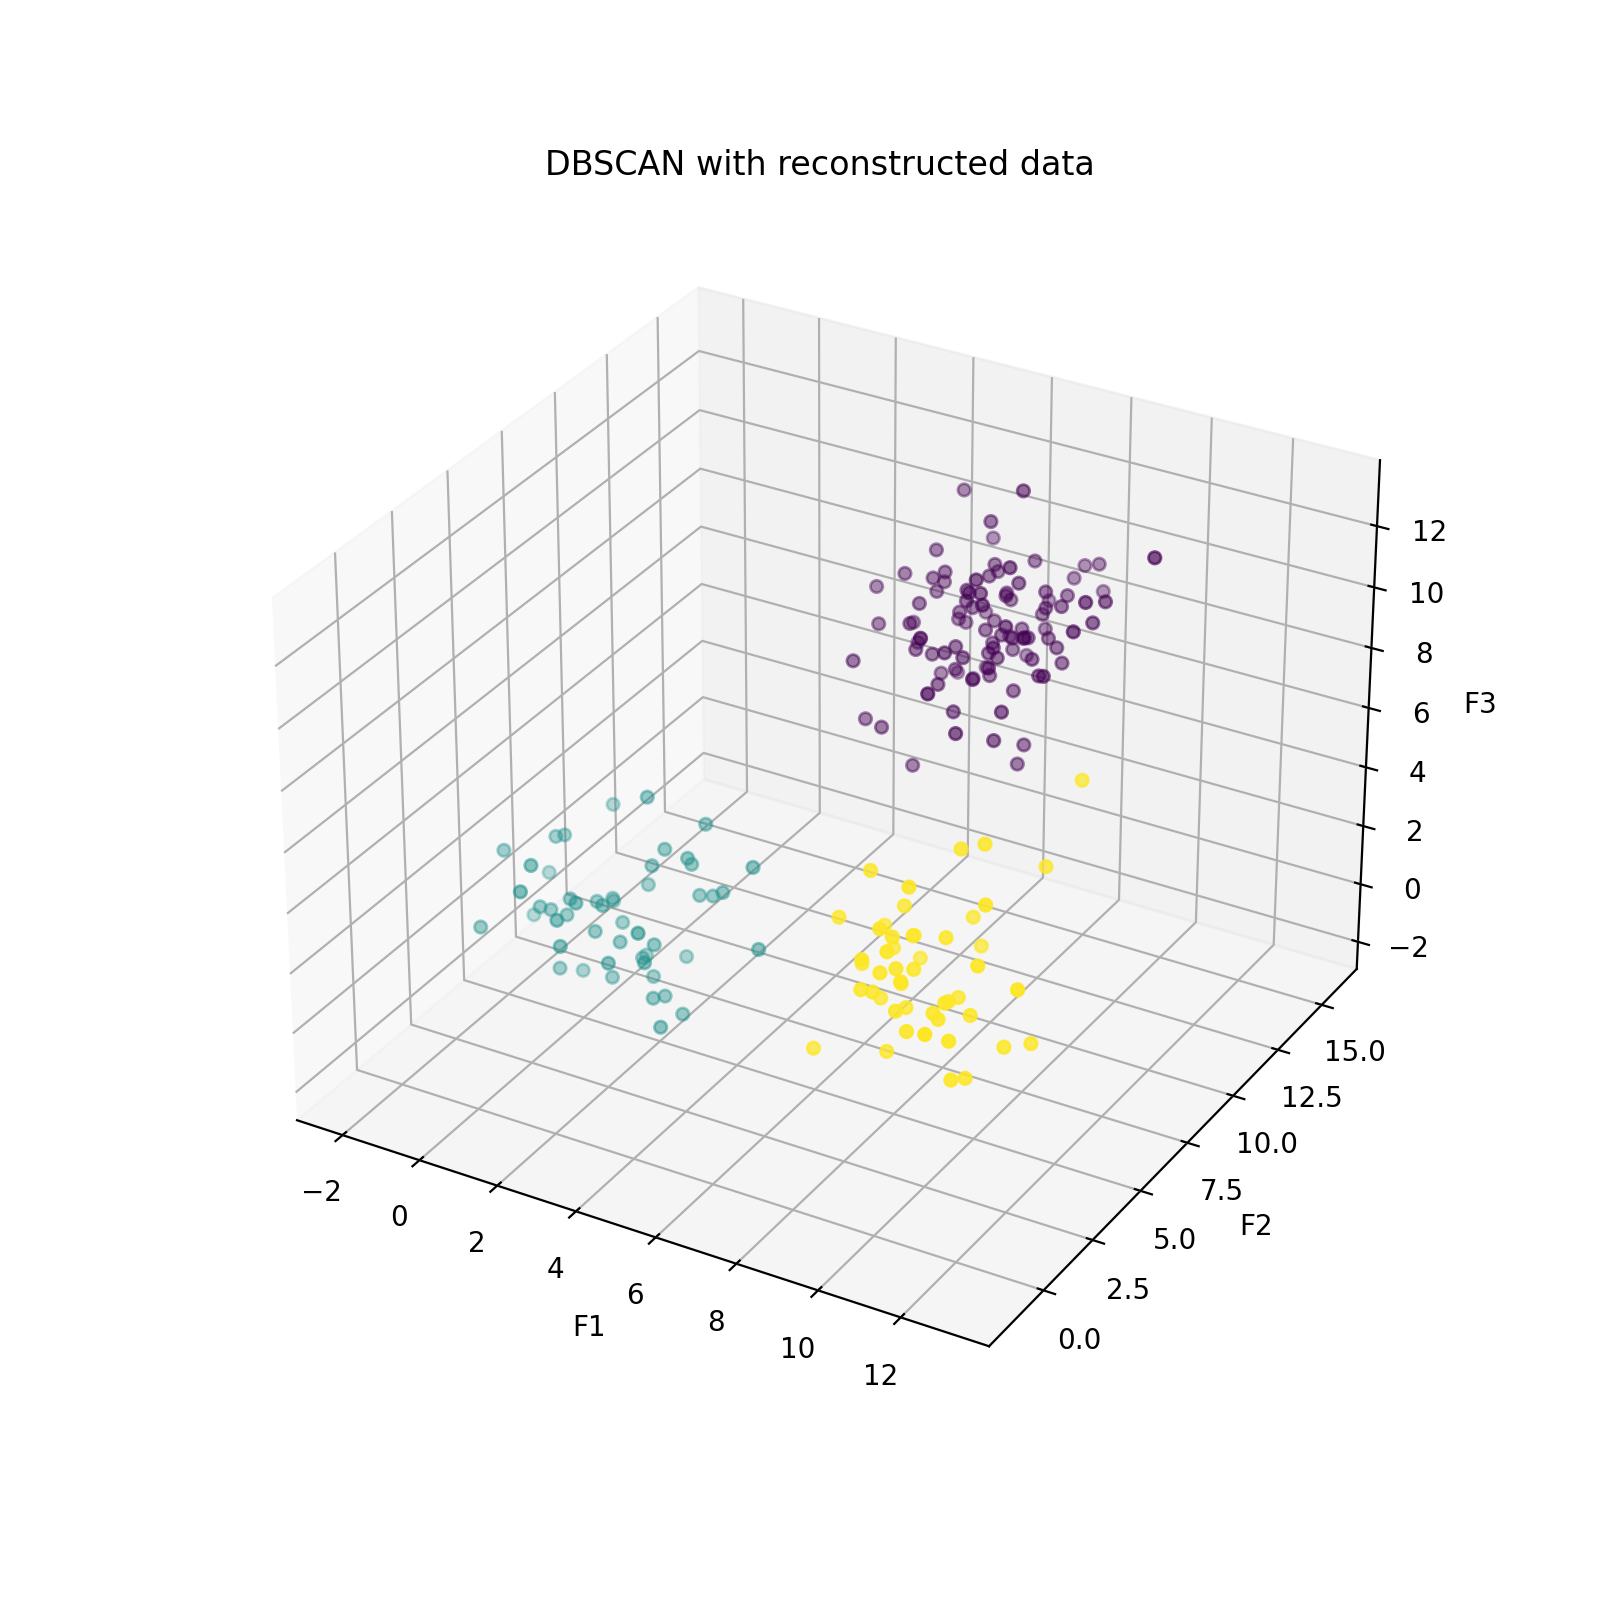

In [19]:
# plot new clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_reconstr[0].iloc[:, 0], features_reconstr[0].iloc[:, 1], features_reconstr[0].iloc[:, 2], c=clusters_reconstr[0])
plt.gca().update(dict(title='DBSCAN with reconstructed data', xlabel='F1', ylabel='F2', zlabel='F3'))
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "3_DBSCAN_imputed_data.png"), **config["plots"])

## 5. Cluster Performance


### 5.1 Feature Distributions
#### 5.1.1 Distr. Plots based on best model predictions

<IPython.core.display.Javascript object>


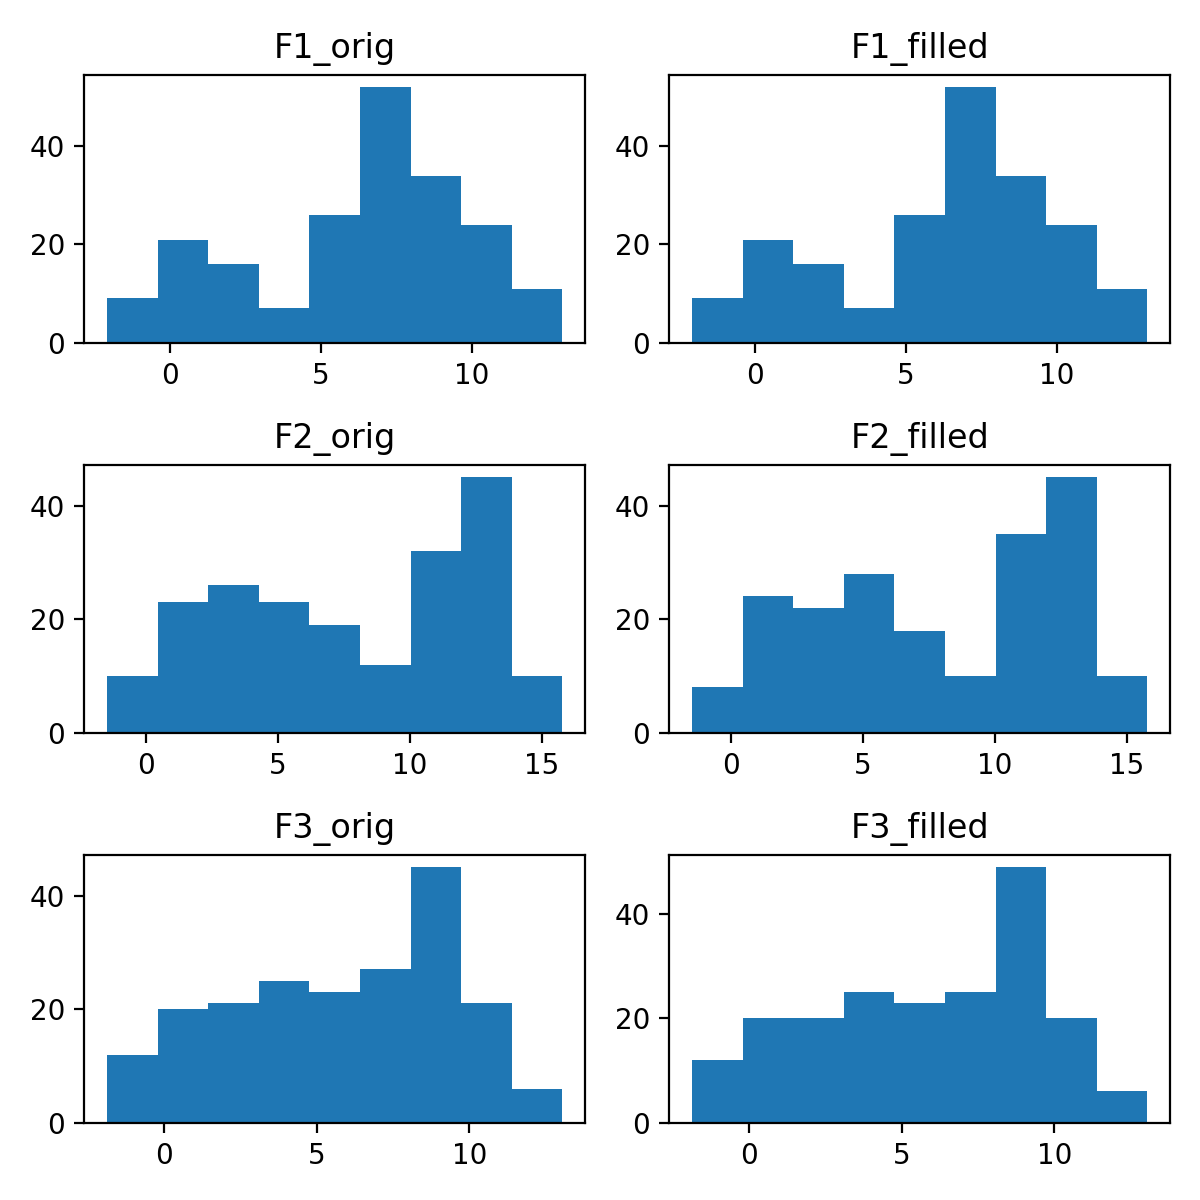

In [20]:
# plot distributions
bins = len(astropy.stats.freedman_bin_width(features[feature], return_bins=True)[1])
n_feat = len(features_best.columns)

fig, (ax) = plt.subplots(n_feat, 2, figsize=(n_feat*2,6))
for n, feature in enumerate(features_best.columns):
    ax[n, 0].hist(features[feature], bins=bins)
    ax[n, 0].set_title(f"{feature}_orig")
    ax[n, 1].hist(features_best[feature], bins=bins)
    ax[n, 1].set_title(f"{feature}_filled")

fig.tight_layout()
plt.show()
if save_output:
    plt.savefig(os.path.join(plots_path, "feature distributions.png"), **config["plots"])

#### 5.1.2 KL Divergence

In [21]:
# KL Divergence
def kl_divergence(feature1, feature2):
    
    # calculate probability distributions
    def probability_dist(x, y, bins):
        # transforms 2 series into their probability distributions
        # histogram
        hist_xy = np.histogram2d(x, y, bins=bins)[0]

        # compute marginals
        hist_xy = hist_xy + sys.float_info.min # prevent division with 0
        hist_xy = hist_xy / np.sum(hist_xy)
        hist_x = np.sum(hist_xy, axis=1)
        hist_y = np.sum(hist_xy, axis=0)
        return(hist_x, hist_y)

    # calculate kl divergence
    bins = len(astropy.stats.freedman_bin_width(feature1, return_bins=True)[1])
    distr1, distr2 = probability_dist(feature1, feature2, bins)
    return torch.nn.functional.kl_div(torch.tensor(distr1).log(), torch.tensor(distr2), log_target=False, reduction='sum').item()

In [22]:
output["kl_divergence"] = {}

# save kl divergence
for run in range(config["RQ2"]["runs"]):
    for feature in features_to_predict:
        output["kl_divergence"][f"run{run}_{feature}"] = kl_divergence(features[feature], features_reconstr[run][feature])

In [23]:
# plot

### 5.2 Silhouette Score

In [24]:
from sklearn.metrics import silhouette_score

output["silhouette_scores"] = {}
output["silhouette_scores"]["orig_data"] = float(silhouette_score(features, np.ravel(clusters)))

for run in range(config["RQ2"]["runs"]):
    output["silhouette_scores"][f"run{run}"] = float(silhouette_score(features_reconstr[run], clusters_reconstr[run]))

In [25]:
# plot

### 5.3. Outlierness
#### 5.3.1 Global outliers (considering all features)

In [26]:
# Outliers detected as noise by DBSCAN
output["cluster_noise"] = {}
output["cluster_noise"][f"original"] = sum(clusters_orig == -1)

for run in range(config["RQ2"]["runs"]):
        output["cluster_noise"][f"run{run}"] = sum(clusters_reconstr[run] == -1)

#### 5.3.1 Local outliers (outlierness within one feature)

In [27]:
# plot global

# plot local

### 5.4. Save Output

In [28]:
with open(output_path, "w") as f:
            toml.dump(output, f)